In [14]:
import pandas as pd
import numpy as np
# check exchange rate correlation USD/PLN with average daily temperature

# use rates and weather data in range(2/28/2022 - 2/20/2023)
import datetime
min_date = datetime.datetime(2022,2,28).date()
max_date = datetime.datetime(2023,2,20).date()

def clean_data_and_reindex_using_date(
    df: pd.DataFrame,
    min_date: datetime.date, 
    max_date: datetime.date, 
    date_label: str, 
    column_label: str,
    column_rename_to: str = ''
) -> pd.DataFrame:

    df['date'] = pd.to_datetime(df[date_label]).dt.date
    cleaned_df = df[df['date'].between(
        min_date, max_date, inclusive='both'
    )]

    return pd.DataFrame(
        list(cleaned_df[column_label]),
        index=cleaned_df.date, 
        columns=[column_rename_to and column_rename_to or column_label]

    )

# normalization
def min_max_nornmalization(series: pd.Series)-> pd.Series:
    mm = series.agg(['min', 'max'])
    return (series - mm['min']) / (mm['max'] - mm['min'])

def get_rate_statictic(rates):
    # statistics
    print('rate statistics')
    rate_min = rates.rate.min()
    rate_mean = rates.rate.mean()
    rate_max = rates.rate.max()
    print(f'min: {rate_min}\nmean: {rate_mean}\nmax: {rate_max}')

    print('standart deviation')
    standart_deviation  = rates.rate.std()

    print(f'standart_deviation: {standart_deviation}')
    # to sell after
    print(f'to sell after USD/PLN: {rate_mean + standart_deviation}')
    # to buy after
    print(f'to buy after USD/PLN: {rate_mean - standart_deviation}')



In [15]:
# create df with exchage rates data
rates = pd.read_csv('rates.csv')
print(rates.dtypes)
rates.describe()

Date      object
Close    float64
dtype: object


,Close
count,401.000000
mean,4.479690
std,0.233271
min,3.935550
25%,4.330150
50%,4.452550
75%,4.657750
max,5.003250


rate    float64
dtype: object


<Axes: xlabel='date'>

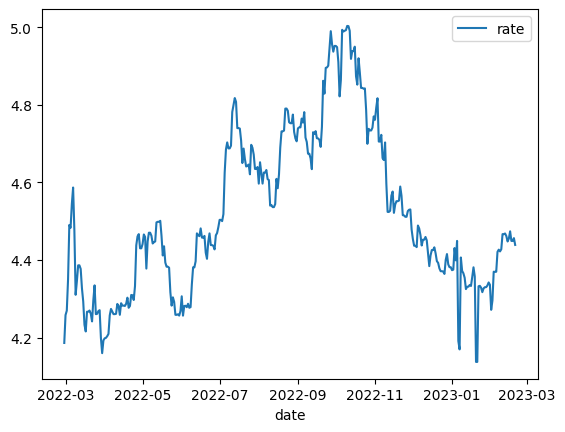

In [16]:
# clean rates
final_rates = clean_data_and_reindex_using_date(
    rates, min_date, max_date, 'Date', 'Close', 'rate'
)
print(final_rates.dtypes)
final_rates.plot()

In [17]:
# create df with weather data
weather = pd.read_csv('weather.csv')
print(weather.dtypes)
weather.describe()

time            object
temperature    float64
dtype: object


,temperature
count,8592.000000
mean,9.727549
std,7.740399
min,-10.100000
25%,3.200000
50%,10.000000
75%,15.200000
max,31.200000


<Axes: xlabel='date'>

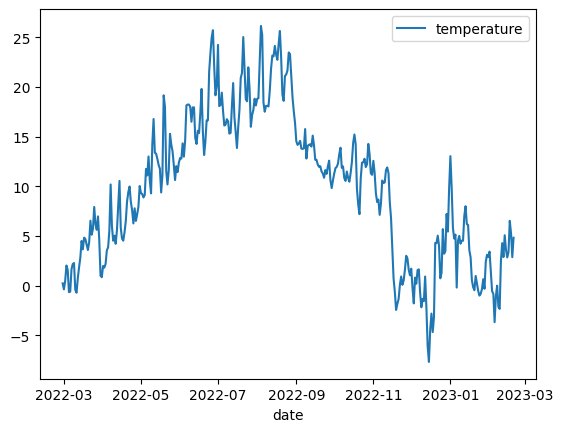

In [18]:
# clean weather
final_weather = clean_data_and_reindex_using_date(
    weather, min_date, max_date, 'time', 'temperature'
).groupby('date').mean()
final_weather.plot()

In [19]:
# create df with unemployment data
unemployment = pd.read_csv('unemployment.csv')
print(unemployment.dtypes)
unemployment.describe()

date                  object
unemployment_rate    float64
dtype: object


,unemployment_rate
count,13.000000
mean,5.369231
std,0.271982
min,5.100000
25%,5.200000
50%,5.200000
75%,5.500000
max,5.900000


<Axes: xlabel='date'>

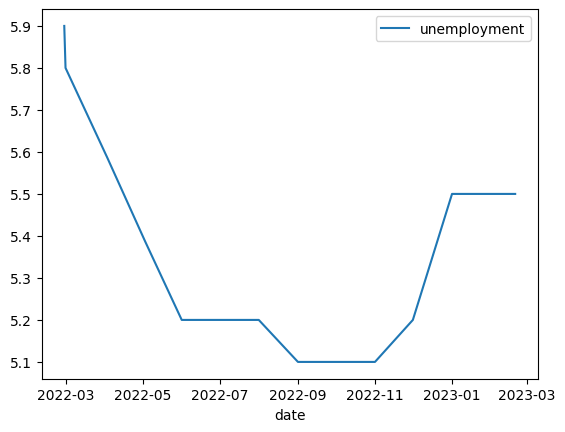

In [20]:
# clean unemployment
unemployment['year'] = pd.to_datetime(unemployment.date).dt.year
unemployment['month'] = pd.to_datetime(unemployment.date).dt.month

rng = pd.date_range('2/28/2022', '2/20/2023', freq='D')
# fill with same values
# unemployment_rate = [
#     (
#         (unemployment[
#             (unemployment['year'] == date.year) 
#             & (unemployment['month'] == date.month) 
#         ]).unemployment_rate.to_list()[0]
#     )
#     for date in rng
# ]

# fill NaN with interpolation
unemployment_rate = []
checked_rates = []
for date in rng:
    ur = (unemployment[
            (unemployment['year'] == date.year) 
            & (unemployment['month'] == date.month) 
        ]).unemployment_rate

    if ur.first_valid_index() not in checked_rates:
        unemployment_rate.append(
            ur.to_list()[0]
        )
    else:
        unemployment_rate.append(np.nan)
    
    checked_rates.append(ur.first_valid_index())

unemployment_series = pd.Series(unemployment_rate).interpolate()

final_uneployment = pd.DataFrame(
    list(unemployment_series),
    index=pd.to_datetime(rng).date, 
    columns=['unemployment']
)
final_uneployment.index.name = 'date'
final_uneployment.plot()

In [21]:
# join tables
merged = pd.merge(final_rates, final_weather, on='date')
merged = pd.merge(merged, final_uneployment, on='date')
merged.describe()

,rate,temperature,unemployment
count,358.000000,358.000000,358.000000
mean,4.516171,9.727549,5.309637
std,0.207635,7.378599,0.196061
min,4.137624,-7.687500,5.100000
25%,4.356631,3.585417,5.147097
50%,4.463945,10.539583,5.200000
75%,4.689050,14.815625,5.500000
max,5.003250,26.145833,5.900000


In [22]:
# statistics
get_rate_statictic(merged)


rate statistics
min: 4.137624
mean: 4.516171304469274
max: 5.00325
standart deviation
standart_deviation: 0.2076353994723007
to sell after USD/PLN: 4.723806703941574
to buy after USD/PLN: 4.308535904996973


In [23]:
print('correlation')
merged.corr(min_periods=3)
# looks like 45% correlation beetwen exchage rate and tempreature

correlation


,rate,temperature,unemployment
rate,1.000000,0.447232,-0.739024
temperature,0.447232,1.000000,-0.605996
unemployment,-0.739024,-0.605996,1.000000


<Axes: xlabel='date'>

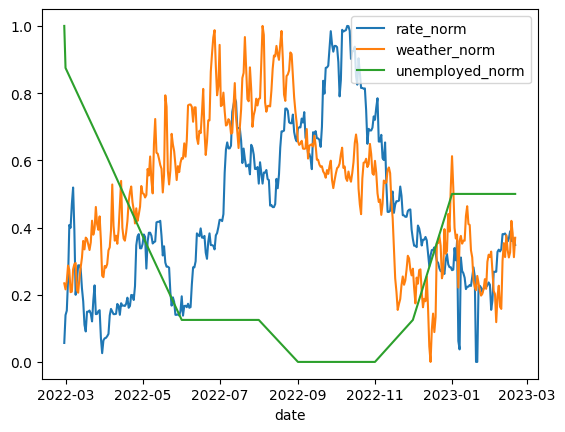

In [24]:
merged['rate_norm'] = min_max_nornmalization(merged.rate)
merged['weather_norm'] = min_max_nornmalization(merged.temperature)
merged['unemployed_norm'] = min_max_nornmalization(merged.unemployment)

merged.loc[:, ['rate_norm', 'weather_norm', 'unemployed_norm']].plot()